In [1]:
#!pip install pandas numpy nltk scikit-learn matplotlib seaborn tensorflow transformers tqdm

# Step 0: Import libraries and packages

In [3]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from IPython.display import display
import nltk
nltk.download('punkt')
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package punkt to /Users/f.nuno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/f.nuno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1: Load the Data

In [4]:
fake = pd.read_csv("datasets/fake-and-real-news-dataset/Fake.csv")
true = pd.read_csv("datasets/fake-and-real-news-dataset/True.csv")

# Assign labels
fake['label'] = 0
true['label'] = 1

# Combine the data
news = pd.concat([fake, true], ignore_index=True)

# Drop unnecessary columns
news.drop(columns=["title", "date", "subject"], inplace=True)

# Remove duplicates
news.drop_duplicates(inplace=True)

# Reset index
news.reset_index(drop=True, inplace=True)

# Display the data
print(news.info())
display(news.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38647 entries, 0 to 38646
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38647 non-null  object
 1   label   38647 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 604.0+ KB
None


,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


# Step 2: Data Cleaning and Preprocessing

In [5]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove unwanted characters
    text = text.lower()  # Convert to lower case
    return text

tqdm.pandas(desc="Cleaning Text")
news['text'] = news['text'].progress_apply(clean_text)

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

tqdm.pandas(desc="Preprocessing Text")
news['text'] = news['text'].progress_apply(preprocess_text)

# Display the cleaned data
display(news.head())

Cleaning Text:   0%|          | 0/38647 [00:00<?, ?it/s]

Preprocessing Text:   0%|          | 0/38647 [00:00<?, ?it/s]

,text,label
0,donald trump wish american happi new year leav...,0
1,hous intellig committe chairman devin nune go ...,0
2,friday reveal former milwauke sheriff david cl...,0
3,christma day donald trump announc would back w...,0
4,pope franci use annual christma day messag reb...,0


# Step 3: Split the Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(news['text'], news['label'], test_size=0.2, random_state=42)

# Step 4: Vectorize the Text Data

In [7]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 5: Model Training and Evaluation

## 5.1 Naive Bayes Classifier

In [7]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9297542043984476
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3500
           1       0.94      0.93      0.94      4230

    accuracy                           0.93      7730
   macro avg       0.93      0.93      0.93      7730
weighted avg       0.93      0.93      0.93      7730



### Confusion matrix

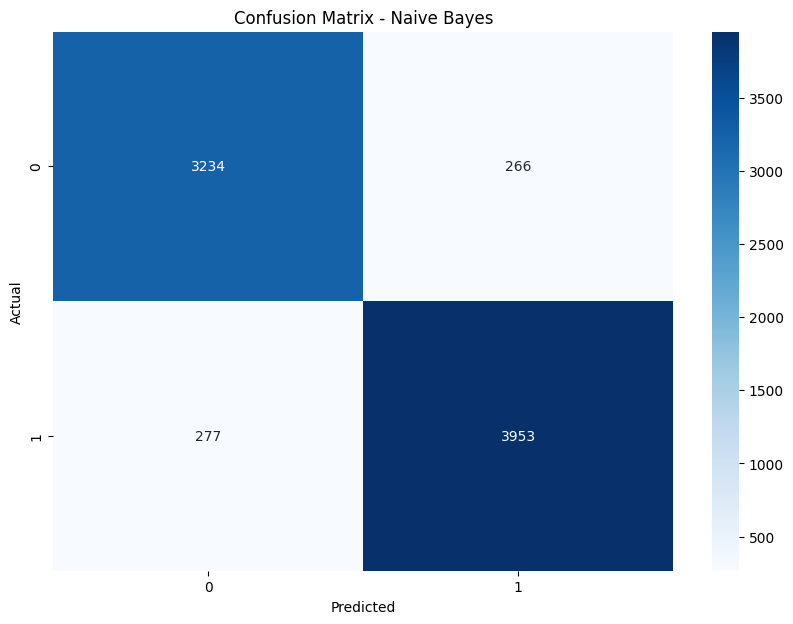

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

## 5.2 LSTM Model

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Epoch 10 - loss: 0.0051 - accuracy: 0.9985
242/242 [==============================] - 18s 74ms/step - loss: 0.0160 - accuracy: 0.9948
LSTM Accuracy: 0.9948253631591797


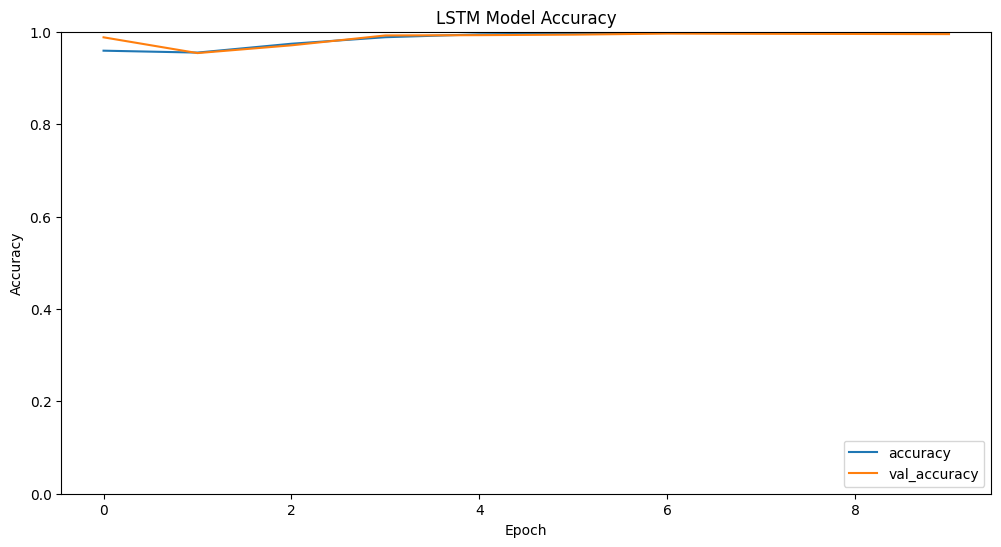

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Tokenizer setup
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(news['text'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
max_len = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Define the custom callback class
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        if logs is not None:
            print(f'Epoch {epoch + 1} - loss: {logs["loss"]:.4f} - accuracy: {logs["accuracy"]:.4f}')
        else:
            print(f'Epoch {epoch + 1} - logs: None')

# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.0))  # Ensure recurrent_dropout is 0
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Create an instance of your custom callback
tqdm_callback = TQDMProgressBar()

# Train your model with the custom callback
history = model.fit(X_train_pad, y_train, epochs=10, callbacks=[tqdm_callback], validation_split=0.2)

# Evaluate the model
lstm_accuracy = model.evaluate(X_test_pad, y_test)[1]
print("LSTM Accuracy:", lstm_accuracy)

# Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('LSTM Model Accuracy')
plt.show()


## 5.3 Transformer Model (BERT)

In [8]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset
import warnings
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# Suppress the specific warning
warnings.filterwarnings("ignore", message="Some weights of BertForSequenceClassification were not initialized from the model checkpoint")

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

# Load the tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# Ensure that X_train and X_test are lists of strings
assert isinstance(X_train, pd.Series) and all(isinstance(item, str) for item in X_train), "X_train should be a Series of strings."
assert isinstance(X_test, pd.Series) and all(isinstance(item, str) for item in X_test), "X_test should be a Series of strings."

# Convert pandas Series to lists
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

# Define tokenization function
def tokenize_and_pad(texts, tokenizer):
    encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=128, return_tensors='pt', return_attention_mask=True)
    return encodings['input_ids'], encodings['attention_mask']
    
# Tokenize and pad the data
train_input_ids, train_attention_mask = tokenize_and_pad(X_train_list, tokenizer)
test_input_ids, test_attention_mask = tokenize_and_pad(X_test_list, tokenizer)

# Convert labels to PyTorch tensors
y_train = torch.tensor(y_train.numpy() if isinstance(y_train, tf.Tensor) else y_train)
y_test = torch.tensor(y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test)

# Create PyTorch datasets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, y_train)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 2
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        
        progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1), 
                                  'accuracy': total_correct / total_samples})
    
    train_loss = total_loss / len(train_dataloader)
    train_accuracy = total_correct / total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_samples = 0
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_samples += labels.size(0)
    
    val_loss = val_loss / len(test_dataloader)
    val_accuracy = val_correct / val_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {train_loss:.4f} - "
          f"accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - "
          f"val_accuracy: {val_accuracy:.4f}")

# Evaluate the model
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print("Test Accuracy:", test_accuracy)

# Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.tight_layout()
plt.show()

Using MPS device


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyError: 4

# Step 6: Model Comparison and Recommendation

In [ ]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("LSTM Accuracy:", lstm_accuracy)
print("BERT Accuracy:", bert_accuracy)

# Recommendation

In [ ]:
best_model = 'BERT' if bert_accuracy > max(accuracy_score(y_test, y_pred_nb), lstm_accuracy) else 'LSTM' if lstm_accuracy > accuracy_score(y_test, y_pred_nb) else 'Naive Bayes'
print(f"Recommended Model: {best_model}")

In [ ]:
print(X_train_pad.shape)  # Should be (num_samples, max_len)
print(X_test_pad.shape)   # Should be (num_samples, max_len)
print(y_train.shape)      # Should be (num_samples,)
print(y_test.shape)       # Should be (num_samples,)